# Calculate performance scores of PII detection models and plot figures
### This notebook takes the results of all PII detetction models as an input and calculates performance scores, entity-based analysis and a confusion matrix. The results file needs to be in a specific format: a dicitionary {"filename": entitiy_predicitions} where entity_predicitons is a list that contains a dictionary {"start": start charcter of entity, "stop": stop character of entity, "entitiy_type": type of detected entity} for each detected entity of a text.

# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime
import os
import json

# Load json files and import score_calculator

In [2]:
import sys
sys.path.append('../src')

# Import score_calculator.py script
import score_calculator as sc

In [3]:
# Load labeled data json file
with open('../data/labels_200_final.json', 'r') as file:
    labels_dict_ls = json.load(file)

# Convert labelled data from Azure Language studio format to dict format used by score_calculator
labels_dict = sc.convert_labels_dict(labels_dict_ls)

In [70]:
# Load PRESIDIO model predictions json file
with open('../model_results/predictions_dict_presidio_2024-04-26_12-19-50_Exp_1.json', 'r') as file:
    pred_dict_Presidio = json.load(file)

# Load GPT3.5 model predictions json file
with open('../model_results/predictions_dict_gpt3.5_20240429.json', 'r') as file:
    pred_dict_GPT = json.load(file)

# Load SAUERKRAUT model predictions json file
with open('../model_results/entity_data_Llama-3-SauerkrautLM-8b-Instruct-GGUF32G.json', 'r') as file:
    pred_dict_Sauerkraut = json.load(file)

# Calculate scores and confusion matrix

In [71]:
# This dictionary can be used to rename entities when they are differently named between model predicitions or lables
# such that they can be mapped onto each other for the confusion matrix

entity_mapping_dict = {
                      "ADDRESS":"ADRESSE",
                      "PHONE_NUMBER": "TELEFONNR.",
                      "PHONENUMBER": "TELEFONNR.",
                      "LOCATION": "ADRESSE",
                      "POSTLEITZAHL": "ADRESSE",
                      "GESCHAEFTSPARTNERNUMMER": "GESCHAEFTSPARTNERNR.",
                      "VERTRAGSNUMMER": "VERTRAGSNR.",
                      "ZAEHLERNUMMER": "ZAEHLERNR.",
                      "RECHNUNGSNUMMER": "RECHNUNGSNR.",
                      "EMAIL_ADDRESS": "EMAIL",
                      "ORT": "ADRESSE",
                      "STRASSE": "ADRESSE",
                      "PLZ": "ADRESSE",
                      "TELEFONNUMMER": "TELEFONNR.",
                      "TELEFON": "TELEFONNR."
                      }

In [72]:
# This function calculates all relevant model scores and metrics from model predicitions and labeled data
# Note that instead of comparing model output with labeled data, also the predicitions from 2 models can be compared
# In case one of the input dicitionaries (e.g. labels_dict) has fewer results than the other (e.g. because not all texts were labeled)
# than this dict has to be passed as the second argument

# Set dictionaries of models or labels that you want to compare
pred_dict = pred_dict_GPT
labels_or_model_dict = labels_dict

metrics_dict_all, score_dict_all = sc.calculate_model_score(
                                                            pred_dict, # dicitionary that contains information about model predicitions for all texts
                                                            labels_or_model_dict, # dicitionary that contains information about labeled texts (ground truth), or predictions from other model
                                                            fuzzy = 3, # defines how many characters difference between 'start' and 'end' value for each entity are allowed when comparing dicts
                                                            entity_mapping_dict = entity_mapping_dict, # rename entities if their are differently named between models or labeled data
                                                            address_merge = True, # set True when comparing Presidio model
                                                            rec_score = False # set True when Recognizer scores for model are available (eg in Presidio model output)
                                                            )

55% of texts (110/200) were perfectly anonymized by the model
Model Precision: 90.34%
Model Recall: 88.94%
Model F1_score: 89.64%
True Positives: 917
False Positives: 98
False Negatives: 114


# Model combination
### Make predicition_dict that only contains texts where 2 models perfectly agree. This can be done iteratively for as many models as necessary

In [73]:
keys_perf_match = [key for key, value in score_dict_all.items() if value.get('f1_score') == 1.0]
dict_models_match = {key: value for key, value in labels_or_model_dict.items() if key in keys_perf_match}

# Save prediction dict where 2 models perfectly overlap:
# with open("dict_Presidio_Sauerkraut_GPT_match.json", 'w') as file:
#    json.dump(dict_Presidio_Sauerkraut_GPT_match, file)

In [74]:
# This function calculates all relevant model scores and metrics from model predicitions and labeled data
# Note that instead of comparing model output with labeled data, also the predicitions from 2 models can be compared
# In case one of the input dicitionaries (e.g. labels_dict) has fewer results than the other (e.g. because not all texts were labeled)
# than this dict has to be passed as the second argument

# Set dictionaries of models or labels that you want to compare
pred_dict = labels_dict
labels_or_model_dict = dict_models_match

metrics_dict_all, score_dict_all = sc.calculate_model_score(
                                                            pred_dict, # dicitionary that contains information about model predicitions for all texts
                                                            labels_or_model_dict, # dicitionary that contains information about labeled texts (ground truth), or predictions from other model
                                                            fuzzy = 3, # defines how many characters difference between 'start' and 'end' value for each entity are allowed when comparing dicts
                                                            entity_mapping_dict = entity_mapping_dict, # rename entities if their are differently named between models or labeled data
                                                            address_merge = True, # set True when you want to merge entites (<ORT>, <PLZ>, <STRASSE>) into single entity <ADRESSE>
                                                            rec_score = False # set True when Recognizer scores for model are available (e.g. in Presidio model output)
                                                            )

100% of texts (110/110) were perfectly anonymized by the model
Model Precision: 100.00%
Model Recall: 100.00%
Model F1_score: 100.00%
True Positives: 552
False Positives: 0
False Negatives: 0


# Calculate and plot confusion matrix

In [75]:
# This function calculates the confusion matrix based on the metrics_dict_all output from the calculate_model_score function
# The confusion matrix is based on the names of the entities. To map differently named entities onto each other, use the entitiy_mapping_dict
# for the calculate_model_score function defined above

confusion_matrix = sc.make_confusion_matrix(metrics_dict_all)

In [76]:
# Calculate adapted performance score that takes into account entity types
# In contrast to the output from the calculate_model_score function, these scores tag a prediction
# as a false positive when the same word was tagged as PII, but a different entity was predicted
# This only makes sense when entity names are matched!

metrics_dict_entities = sc.score_from_confusion_matrix(confusion_matrix)

Model Performance based on Entity Type:
Model Precision: 98.55%
Model Recall: 100.00%
Model F1_score: 99.27%
True Positives: 544
False Positives: 8
False Negatives: 0


## Make confusion matrix plot

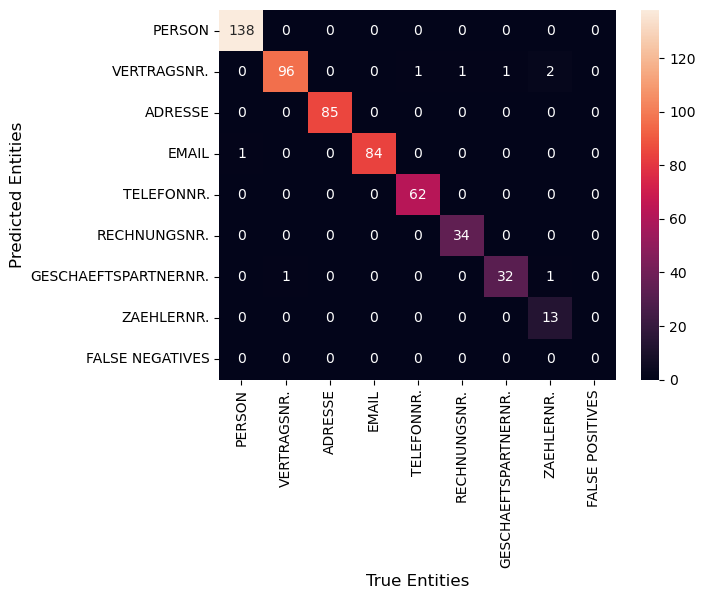

In [77]:
# Plot the confusion matrix
fig_cm = sc.plot_confusion_matrix(confusion_matrix)

# Make entity bar plot

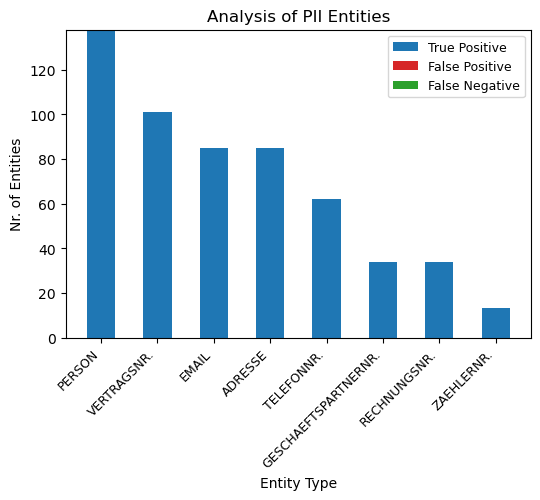

In [78]:
# Plot a barplot of all entities and whether they were correctly predicted (true positive), wrongly predicted (false positive), or missed (false negative)
fig_bars = sc.plot_entity_barplot(metrics_dict_all)

# Make model performance scores plot

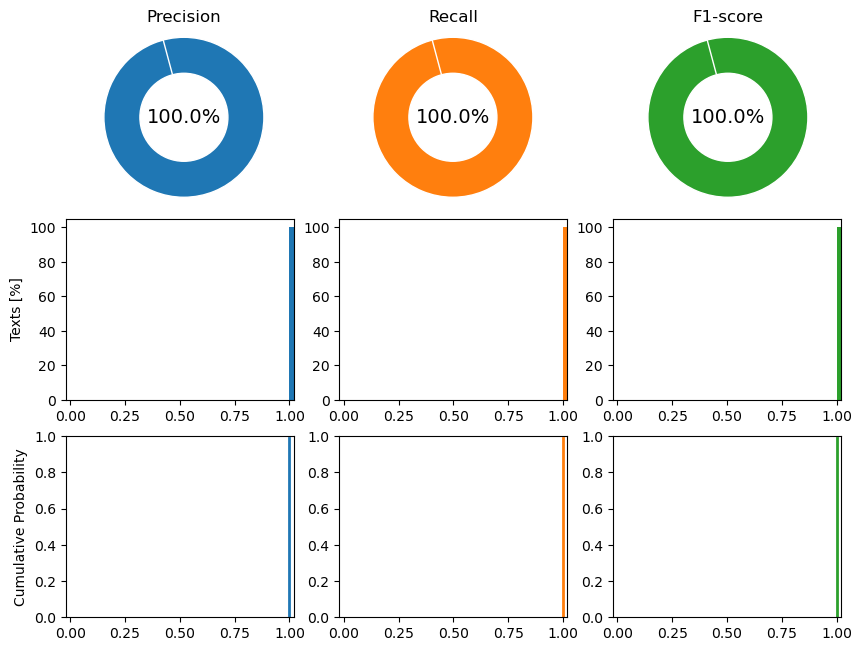

In [79]:
# Plot Precision, Recall, F1-score and their distributions
fig_scores = sc.plot_scores(metrics_dict_all)

# Save plots and results dictionaries on Google Drive

## Save plots as .png files

In [80]:
import pytz

# Set foldername and filenames for saving data
file_ext = "_GPT+Presidio"  # set string for filenames
current_dt = datetime.now(pytz.timezone('Europe/Berlin')).strftime("%Y-%m-%d_%H-%M-%S")  # get current datetime for filenames

# Create a new folder with datetime
new_folder_name = os.path.join("..", "reports", current_dt + file_ext)
os.makedirs(new_folder_name, exist_ok=True)

# Save confusion matrix plot
fig_cm_path = os.path.join(new_folder_name, "confusion_matrix_plot_" + current_dt + file_ext + ".png")
fig_cm.savefig(fig_cm_path, dpi=300, bbox_inches="tight")

# Save entities barplot
fig_bars_path = os.path.join(new_folder_name, "entities_barplot_" + current_dt + file_ext + ".png")
fig_bars.savefig(fig_bars_path, dpi=300, bbox_inches="tight")

# Save scores plot
fig_scores_path = os.path.join(new_folder_name, "scores_" + current_dt + file_ext + ".png")
fig_scores.savefig(fig_scores_path, dpi=300, bbox_inches="tight")

# Optional: Remove the figure objects if no longer needed
plt.close(fig_cm)
plt.close(fig_bars)
plt.close(fig_scores)

## Save metrics_dict and score_dict as .json

In [81]:
new_folder_name = os.path.join("..", "model_scores", current_dt + file_ext)
os.makedirs(new_folder_name, exist_ok=True)

# Set filenames of json files
score_dict_filename = os.path.join(new_folder_name, "score_dict_" + current_dt + file_ext + ".json")
metrics_dict_filename = os.path.join(new_folder_name, "metrics_dict_" + current_dt + file_ext + ".json")

# Save score and metrics dictionaries as json files
with open(score_dict_filename, 'w') as score_file:
    json.dump(score_dict_all, score_file)

with open(metrics_dict_filename, 'w') as metrics_file:
    json.dump(metrics_dict_all, metrics_file)